In [42]:
import os, h5py, re, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = False

In [43]:
# ✏️ Update this to the file you want to analyze
H5_PATH = Path("../data/eda/t15.2023.08.13/data_train.hdf5")
assert H5_PATH.exists(), f"Not found: {H5_PATH}"
H5_PATH

PosixPath('../data/eda/t15.2023.08.13/data_train.hdf5')

In [44]:
rows = []
with h5py.File(H5_PATH, "r") as f:
    for trial_key in f.keys():
        g = f[trial_key]
    
        input_features = g['input_features'][:]
        n_time_steps = g.attrs['n_time_steps']
        seq_class_ids = g['seq_class_ids'][:] if 'seq_class_ids' in g else None
        seq_len = g.attrs['seq_len'] if 'seq_len' in g.attrs else None
        transcription = g['transcription'][:] if 'transcription' in g else None
        sentence_label = g.attrs['sentence_label'][:] if 'sentence_label' in g.attrs else None
        session = g.attrs['session']
        block_num = g.attrs['block_num']
        trial_num = g.attrs['trial_num']

        rows.append({
            "trial_key": trial_key,
            "session": session,
            "block_num": block_num,
            "trial_num": trial_num,
            "n_time_steps": n_time_steps,
            # "seq_class_ids": seq_class_ids, - byte array
            "seq_len": seq_len,
            # "transcription": transcription, - byte array
            "sentence_label": sentence_label,
            "word_count": len(sentence_label.split())
        })

df_trials = pd.DataFrame(rows)
df_trials.head()

,trial_key,session,block_num,trial_num,n_time_steps,seq_len,sentence_label,word_count
0,trial_0000,t15.2023.08.13,1,0,1023,42,Which is most unfortunate because we all lose ...,9
1,trial_0001,t15.2023.08.13,1,1,1210,46,I had a nineteen seventy eight version before ...,10
2,trial_0002,t15.2023.08.13,1,2,867,32,You get back into a political thing.,7
3,trial_0003,t15.2023.08.13,1,3,972,34,In San Antonio it was like every day.,8
4,trial_0004,t15.2023.08.13,1,4,745,23,Do you stay home with yours?,6


In [45]:
# Create additional columns
df_trials["duration_sec"] = df_trials["n_time_steps"] * 0.02
df_trials["char_count"] = df_trials["sentence_label"].str.len()

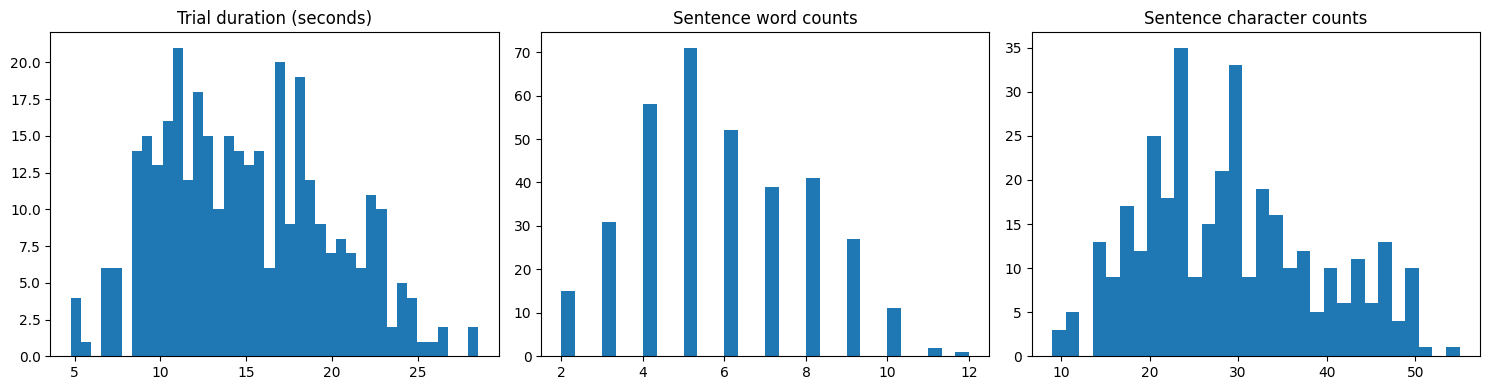

In [46]:
# Explore distributions

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15,4))

axes[0].hist(df_trials["duration_sec"], bins=40)
axes[0].set_title("Trial duration (seconds)")

axes[1].hist(df_trials["word_count"], bins=30)
axes[1].set_title("Sentence word counts")

axes[2].hist(df_trials["char_count"], bins=30)
axes[2].set_title("Sentence character counts")

plt.tight_layout()
plt.show()

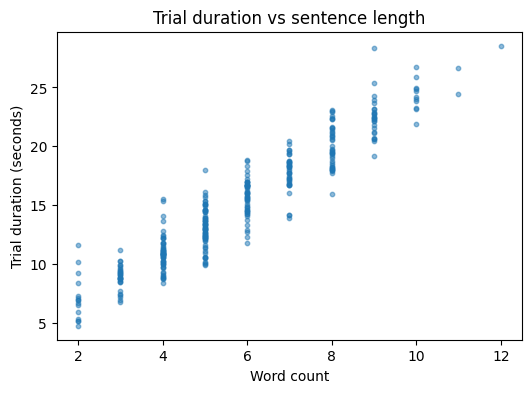

In [47]:
# Relationships between inputs and outputs
plt.figure(figsize=(6,4))
plt.scatter(df_trials["word_count"], df_trials["duration_sec"], alpha=0.5, s=10)
plt.xlabel("Word count")
plt.ylabel("Trial duration (seconds)")
plt.title("Trial duration vs sentence length")
plt.show()

In [48]:
# Shortest / longest by duration
print("Shortest trials:")
display(df_trials.nsmallest(5, "duration_sec")[["trial_key","duration_sec","sentence_label"]])

print("\nLongest trials:")
display(df_trials.nlargest(5, "duration_sec")[["trial_key","duration_sec","sentence_label"]])

# Shortest / longest by word count
print("Fewest words:")
display(df_trials.nsmallest(5, "word_count")[["trial_key","word_count","sentence_label"]])

print("\nMost words:")
display(df_trials.nlargest(5, "word_count")[["trial_key","word_count","sentence_label"]])

# Shortest / longest by character count
print("\nFewest characters:")
display(df_trials.nsmallest(5, "char_count")[["trial_key","char_count","sentence_label"]])

print("\nMost characters:")
display(df_trials.nlargest(5, "char_count")[["trial_key","char_count","sentence_label"]])


Shortest trials:


,trial_key,duration_sec,sentence_label
259,trial_0259,4.78,Coming here.
278,trial_0278,5.18,How right.
290,trial_0290,5.18,Good faith.
286,trial_0286,5.34,Very right.
307,trial_0307,5.92,Bring up.



Longest trials:


,trial_key,duration_sec,sentence_label
319,trial_0319,28.54,I had a friend that broke up with me two years...
326,trial_0326,28.38,I'm not that up on the policy of ways.
85,trial_0085,26.74,And you really begin to develop an interest in...
325,trial_0325,26.66,He helps me out a lot and I get paid monthly.
323,trial_0323,25.86,We do a lot of things on the weekends together.


Fewest words:


,trial_key,word_count,sentence_label
19,trial_0019,2,Light reading.
60,trial_0060,2,Multiple versions.
110,trial_0110,2,Final version.
127,trial_0127,2,Residential situations.
145,trial_0145,2,Ground invasion.



Most words:


,trial_key,word_count,sentence_label
319,trial_0319,12,I had a friend that broke up with me two years...
10,trial_0010,11,If I don't have a reel with a button on it.
325,trial_0325,11,He helps me out a lot and I get paid monthly.
1,trial_0001,10,I had a nineteen seventy eight version before ...
15,trial_0015,10,Heat oil in a medium pan over medium high heat.



Fewest characters:


,trial_key,char_count,sentence_label
242,trial_0242,9,The void.
307,trial_0307,9,Bring up.
278,trial_0278,10,How right.
286,trial_0286,11,Very right.
290,trial_0290,11,Good faith.



Most characters:


,trial_key,char_count,sentence_label
1,trial_0001,55,I had a nineteen seventy eight version before ...
319,trial_0319,51,I had a friend that broke up with me two years...
0,trial_0000,50,Which is most unfortunate because we all lose ...
85,trial_0085,50,And you really begin to develop an interest in...
167,trial_0167,50,Needs and wants aren't necessarily the same th...


In [51]:
# Sentence Content Correlation
df_trials[["n_time_steps","word_count","char_count"]].corr()

,n_time_steps,word_count,char_count
n_time_steps,1.000000,0.948260,0.910238
word_count,0.948260,1.000000,0.903748
char_count,0.910238,0.903748,1.000000


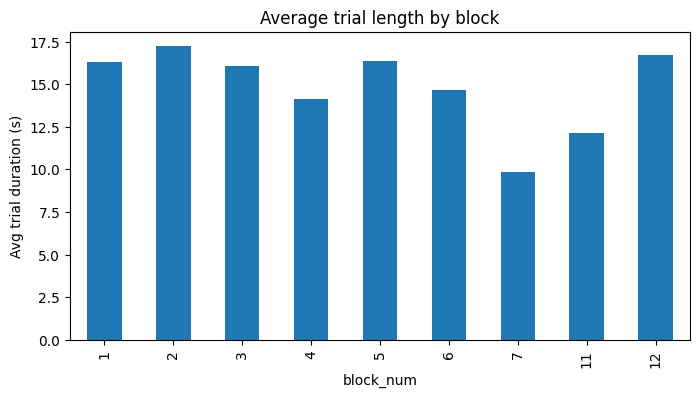

In [49]:
df_trials.groupby("block_num")["duration_sec"].mean().plot(kind="bar", figsize=(8,4))
plt.ylabel("Avg trial duration (s)")
plt.title("Average trial length by block")
plt.show()